

# Background Note 

# Ordinary Least Squares: Multiple OLS

# By Albert S. Kyle

$\def \sm {} \renewcommand{\sm}{ {\scriptstyle{\text{*}}}}$ 
$\def \mm {} \renewcommand{\mm}{{\scriptsize @}}$
$\def \E {} \renewcommand{\E}{\mathrm{E}}$
$\def \e {} \renewcommand{\e}{\mathrm{e}}$
$\def \drm {} \renewcommand{\drm}{\mathrm{\, d}}$
$\def \var {} \renewcommand{\var}{\mathrm{var}}$
$\def \cov {} \renewcommand{\cov}{\mathrm{cov}}$
$\def \corr {} \renewcommand{\corr}{\mathrm{corr}}$
$\def \stdev {} \renewcommand{\stdev}{\mathrm{stdev}}$
$\def \t {} \renewcommand{\t}{^{\mathsf{T}}}$
$\def \comma {} \renewcommand{\comma}{\, , \,}$
$\def \vec {} \renewcommand{\vec}[1]{\mathbf{#1}}$
$\def \skew {} \renewcommand{\skew}{\mathrm{skew}}$
$\def \kurt {} \renewcommand{\kurt}{\mathrm{kurt}}$
$\def \prob {} \renewcommand{\prob}{\textrm{prob}}$
$\def \midx {} \renewcommand{\midx}{\, \mid \,}$
$\def \argmin {} \renewcommand{\argmin}[1]{\underset{#1}{\mathrm{argmin}}}$


In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import timeit
import math
import statistics
import nbconvert

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NumPy version ' + np.__version__)
print('SciPy version ' + scipy.__version__)
print('matplotlib version ' + matplotlib.__version__)

timestamp = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
print("Timestamp:", timestamp)
tstart = timeit.default_timer()


Python version 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
Pandas version 2.2.3
NumPy version 1.26.4
SciPy version 1.15.1
matplotlib version 3.10.0
Timestamp: 2025-0902-1626


### Introduction

This note considers **ordinary least squares** (**OLS**) with an arbitrary number of independent variables.

OLS is a mathematical procedure which minimizes the **sum of squared errors** (or **mean squared error**) to approximate a **dependent variable** (left-hand side variable) as a linear function of one or more **independent variables** (right-had side variables).

OLS can be used as a statistical method for estimating a **linear regression model**. A regression model imposes a statistical structure on the data.

In this note, we ignore any probabilistic statistical structure. Instead, we focus on OLS as a methodology for describing or approximating data as a linear function of other data.

This reduces the problem to one involving **matrix algebra** but not **statistics**.

### The Problem

Let $\vec{y} = (\vec{y}[0], \ldots, \vec{y}[N-1])$ be a vector of values for a **dependent variable**. Let $\vec{x}_0$, $\ldots$, $\vec{x}_{M-1}$ be $M$ vectors $\vec{x}_m = (\vec{x}_m[0], \ldots, \vec{x}_m[N-1])$ of **independent variables**.  We would like to approximate or describe the vector $\vec{y}$ as a linear function of the explanatory variables $\vec{x_0}$, $\ldots$, $\vec{x_{M-1}}$:

\begin{equation}
y[n] \approx \sum_{m=0}^{M-1} b_m \sm \vec{x}_m[n], \qquad n=0, \ldots, N-1 .
\end{equation}

If the linear function has a constant term, we can think of one of the vectors $\vec{x}_m$, typically $\vec{x}_0$, as being a vector of ones.

### Example: Fitting a polynomial

Consider the problem of fitting a polynomial of degree $M-1$ to a given scalar-to-scalar function $f(t)$ defined over an interval $[t_{\text{min}}, t_{\text{max}}]$. For illustrative purposes, we choose the function $f(t)$ as `np.exp` and the interval as $[-1,+1]$.

We will use OLS to fit the polynomial $p(t) := \sum_{m=0}^{M-1} b_m \sm t^{m}$ to a sorted list of sample points $\vec{t} := ( \vec{t}[0], \vec{t}[1], \ldots, \vec{t}[N-1])$ satisfying $t_{\text{min}} \le \vec{t}[0] \le \vec{t}[0] \le \ldots \le \vec{t}[N-1] \le t_{\text{max}}$.

Define a set of points to be fit, $\vec{y} := f(\vec{t})$, where $f(\vec{t})$ for a vector argument $\vec{t}$ denotes the **element-by-element** values of the function (i.e., $\vec{y}[n] = f(\vec{t}[n])$). Define a matrix of explanatory variables $\vec{X}$ as an $N \times M$ matrix with $\vec{X}[n, m] = \vec{t}[n]^m$, $m=0,\ldots,M-1$. The $m\!$ th column of $\vec{X}$ represents the elements of $\vec{t}$ raised to the $m\!$ th power.

### Python advice for novices:

1. Set the problem up so that numerical calculations can be performed using the Python packages Numpy and Scipy, which are optimized for numerical calculations and have specialized functions already defined for efficiently accomplishing taskes like we are attempting to perform.  

2. It is likely to be inefficient to write slow Python loops of the form `for n in range(N): [...do something numerical...]`, if loopping over a large number of elements.

3. To avoid Python loops, it is helpful if the function $f$ is defined so that it returns a scalar result for a scalar argument and returns an element-by-element array when the argument is an array. Numpy calls such functions **universal functions** (`ufunc`). Many basic Numpy functions, such as `np.exp` and `np.log`, are `ufunc`s. When you define functions using Numpy, they will often automatically be universal functions. Such functions will also attempt to **broadcast** elements and will be **vectorizd** so that looping is fast.

We will build a function `f_poly_fit` to accomplish our task. Here is a start, which generates the data to define $\vec{y}$ and $\vec{X}$. We will add code for OLS later:

In [2]:
def f_poly_fit_OLS(fun, t0=0.00, t1=1.00, nobs=11, degree=3):
    N = nobs
    M = degree + 1
    t = np.linspace(start=t0, stop=t1, num=N, endpoint=True, retstep=False, dtype=np.float64)
    y = fun(t)
    x = t.reshape(N,1)**np.array(range(M)).reshape(1, M)
    
    print(f"{fun=}\n{t0=}\n{t1=}\n{y=}\n{x=}")
    print(f"{t.dtype=}, {x.dtype=}, {y.dtype=}")
    
    #TODO: Add rest of code to fit data with OLS

f_poly_fit_OLS(fun=np.exp)

fun=<ufunc 'exp'>
t0=0.0
t1=1.0
y=array([1.        , 1.10517092, 1.22140276, 1.34985881, 1.4918247 ,
       1.64872127, 1.8221188 , 2.01375271, 2.22554093, 2.45960311,
       2.71828183])
x=array([[1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.1  , 0.01 , 0.001],
       [1.   , 0.2  , 0.04 , 0.008],
       [1.   , 0.3  , 0.09 , 0.027],
       [1.   , 0.4  , 0.16 , 0.064],
       [1.   , 0.5  , 0.25 , 0.125],
       [1.   , 0.6  , 0.36 , 0.216],
       [1.   , 0.7  , 0.49 , 0.343],
       [1.   , 0.8  , 0.64 , 0.512],
       [1.   , 0.9  , 0.81 , 0.729],
       [1.   , 1.   , 1.   , 1.   ]])
t.dtype=dtype('float64'), x.dtype=dtype('float64'), y.dtype=dtype('float64')


### Problem 1 (very easy)

Answer each question with one simple sentence:

1. What does the functions `reshape(N,1)` and `reshape(1,M)` actually do?  What is the purpose of using the `reshape` function in this problem? Instead of `reshape(N,1)`, verify that you obtain the same result with the "shortcut" `reshape(-1,1)`. Which is the safer and more transparent coding strategy, using or avoiding $-1$?

2. Why is the `dtype` of `t` equal to `np.float64`? How would change the `dtype` to `np.float32`? What happens if the `dtype` argument is omitted? 

Hint: Use the Numpy documentation to answer these questions if trial and error does not make it obvious.

### The objective function

**OLS** minimizes the **sum of squared errors**, which is defined by the objective function

\begin{equation}
f_{obj}(b_0, \ldots, b_M) := \sum_{n=0}^{N-1} \left( y_n - b_1 \sm x_{0, n} - \ldots - b_{M-1} \sm x_{M-1, n} \right)^2 .
\end{equation}

To express this in a more compact manner, stack the $M$ column vectors $\vec{x}_m$ horizontally into an $N \times M$ matrix $\vec{X}$, where the $m\!$ th column of $\vec{X}$ is the vector $\vec{x}_m$.  Also, stack the linear coefficients into an $M \times 1$ vector $\vec{b} = (b_0, \ldots, b_M)$. The matrix-vector product $\vec{X} \mm \vec{b}$ is a vector of length $N$ which approximates $\vec{y}$. The approximation errors, called **residuals**, are given compactly in matrix notation by $\vec{y} - \vec{X} \mm \vec{b} $.

We can now express the objective function as

\begin{equation}
f_{obj}(\vec{b}; \vec{y}, \vec{X}) :=  \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm  \left( \vec{y} - \vec{X} \mm \vec{b} \right).
\end{equation}

Here, in the definition of the objective function $f_{obj}(\vec{b}; \vec{y}, \vec{X})$, the $\vec{b}$ before the semi-colon means that $f_{obj}$ is a function of the vector of parameters $\vec{b}$. The $\vec{y}$ and $\vec{X}$ after the semi-colon remind us that the function depends on the data $\vec{y}$ and $\vec{X}$ as inputs.

The mathematical problem for OLS is to find the value of the $M$ OLS coefficients $\vec{b}$ which minimizes the objective function:

\begin{equation}
\begin{aligned}
\hat{\vec{b}} &:= \argmin{\vec{b}} \left[ f_{obj}(\vec{b}; \vec{y}, \vec{X}) \right] \\
&= \argmin{\vec{b}} \left[ \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t  \mm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \right].
\end{aligned}
\end{equation}

Obviously, the least-squares minimizing vector $\hat{\vec{b}}$ is a function of $\vec{X}$ and $\vec{y}$.


### Mathematical Solution: First-order conditions and Normal Equations

The **gradient** of the objective function is defined as its derivative with respect to the vector $\vec{b}$. This derivative is a vector of length $M$ (the number of parameters, which is the number of elements in $\vec{b}$), whose $m\!$ th component is the partial derivative of the objective function with respect to $m\!$ th component of $\vec{b}$. This **gradient vector** is sometimes written as a row vector and sometimes as a column vector. Here we make it a columan vector and express the derivative in matrix notation as

\begin{equation}
f'_{obj} \left( \vec{b}; \vec{y}, \vec{X} \right) = -2 \sm  \vec{X} \t \mm \left( \vec{y} - \vec{X} \mm \vec{b} \right) .
\end{equation}

At the minimum value of the objective function, the gradient vector is equal to the $M \times 1$ zero vector, denoted $\vec{0}_M$ or simply $\vec{0}$ when $M$ can be inferred from the context. If the gradient is not zero, the objective function can be improved locally by changing $\vec{b}$ by a small amount in the direction opposite the gradient. If the gradient is zero, small changes in the gradient do not affect the objective function much. This intuition gives us the first-order conditions, which can be written in vector notation as

\begin{equation}
-2 \sm  \vec{X} \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) = \vec{0} .
\end{equation}

The first-order conditions are equivalent to the **normal equations**

\begin{equation}
\vec{X} \t \mm \vec{X} \mm \hat{\vec{b}} = \vec{X} \t \mm \vec{y} .
\end{equation}

The normal equations are a system of linear matrix equations of the form $\vec{A} \mm \vec{b} = \vec{c}$, where $\vec{A} = \vec{X} \t \mm \vec{X}$ is a known positive semi-definite $M \times M$ matrix, $\vec{c} = \vec{X} \t \mm \vec{y}$ is a known $M \times 1$ vector, and $\hat{\vec{b}}$ is an unknown vector of OLS coefficient estimates to be solved for. 

The second derivative of the objective function is an $M \times M$ **hessian** matrix given by

\begin{equation}
f''_{obj} \left( \vec{b}; \vec{y}, \vec{X} \right) = 2 \sm  \vec{X} \t \mm \vec{X} .
\end{equation}

This matrix is **positive semi-definite** since it is the **transpose product** of a matrix with itself. Therefore, the first-order conditions actually define a minimum to the objective function and not a maximum or **saddle point**. (Note: For arbitrary functions, the first-order conditions do not always define a global minimum if the hessian is negative semi-definite; an example is the function $f(x) = x^3$, which does not have a minimum at $x=0$. For quadratic functions, the first-order conditions do define a global minimum when the hession is positive semidefinite. The global minimum is unique if the hessian is negative definite.) 

Any solution $\hat{\vec{b}}$ to the normal equations gives us OLS coefficients which minimize the sum of squared errors.

If the matrix $\vec{X}$ has full rank $M$ (assuming $M < N$, i.e., more observations that variables), then $\vec{X} \t \vec{X}$ is **invertible**, and the solution will be unique. If $\vec{X}$ has rank less than $M$, $\vec{X}$ has **multicollinearity**, $\vec{X} \t \vec{X}$ is **singular**, and the solution will not be unique. One way to deal with this is to drop just enough linearly dependent columns of $\vec{X}$ to make the the reduced matrix have full rank. 

### Problem 2: Understand the linear algebra (easy)

Make sure that you understand the linear algebra in the previous cell.  It permeates everything in statistics and machine learning.

1. How can you infer from the context of the equation $-2 \sm  \vec{X} \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) = \vec{0}$ that $\vec{0}$ has length $M$?

2. If you are calculating $\vec{X} \t \mm \vec{X} \mm \vec{b}$, is it better to calculate $(\vec{X} \t  \mm\vec{X}) \mm \vec{b}$ or $\vec{X} \t \mm (\vec{X} \mm \vec{b})$?

3. Provide a one-line proof that the product of a matrix with its own transpose, such as $\vec{X} \t \mm \vec{X}$, is positive semi-definite.

4. Why do the first- and second-order conditions guarantee a global minimum and not a global maximum, local minimum, or something else?

5. Based on the assumptions so far, why is the global minimum not necessarily unique?

### Example: Implementing OLS using Python

There are many ways to calculate the OLS coefficients $\hat{\vec{b}}$ using Python packages.  Let's calculate a solution first, then examine how the solution is obtained afterwards.

An obvious Numpy solution uses the least-squares function `np.linalg.lstsq(...)`. This function returns a 4-tuple. The desired OLS coefficients are the first element in the tuple.

Using `np.linagl.lstsq(...)`, we can redefine the function `f_poly_fit_OLS` so that it calculates the OLS coefficients as well as other information:

t.shape=(100,)
y.shape=(100,)
x.shape=(100, 6)
bhat.shape=(6,)
yhat.shape=(100,)


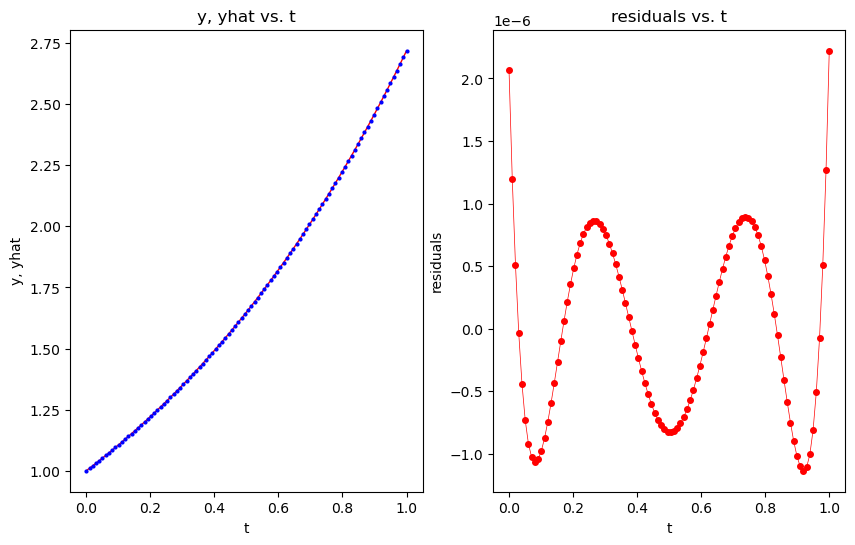

In [3]:
def f_poly_fit_OLS(fun, t0=0.00, t1=1.00, nobs=101, degree=3, bplot=True):
    N = nobs
    M = degree + 1
    t = np.linspace(start=t0, stop=t1, num=N, endpoint=True, retstep=False, dtype=np.float64)
    y = fun(t)
    x = t.reshape(N, 1)**np.array(range(M)).reshape(1, M)
    
    print(f"{t.shape=}\n{y.shape=}\n{x.shape=}")
    #print(f"{f=}\n{t0=}\n{t1=}\n{y=}\n{x=}")
    #print(f"{t.dtype=}, {x.dtype=}, {y.dtype=}")
    
    bhat, sse, rank, singular_values = np.linalg.lstsq(x, y, rcond=None)
    yhat = x @ bhat
    residuals = y - yhat
    
    print(f"{bhat.shape=}\n{yhat.shape=}")
    #print(f"{bhat=}\n{yhat=}")

    if bplot == True:
        fig, ax = plt.subplots(1, 2, figsize=[10,6])
        ax[0].set_title("y, yhat vs. t")
        ax[0].set_xlabel("t")
        ax[0].set_ylabel("y, yhat")
        ax[0].plot(t, y, 'r-', ms=4.00, lw=1.00, label= None)
        ax[0].plot(t, yhat, 'bo', ms=2.00, lw=0.10, label= None)
        ax[1].set_title("residuals vs. t")
        ax[1].set_xlabel("t")
        ax[1].set_ylabel("residuals")
        ax[1].plot(t, residuals, 'ro-', ms=4.00, lw=0.50, label= None)
        plt.show()
    

f_poly_fit_OLS(fun=np.exp, nobs=100, degree=5, bplot=True)


### Proof without gradients and hessians

One way to show that the normal equations (or first-order conditions) characterize the solution, without using gradients and hessians, is to change a proposed solution $\hat{\vec{b}}$ by some arbitrary amount $\Delta \vec{b}$, then recalculate the objective function:

\begin{equation}
\begin{aligned}
f_{obj} \left( \vec{b}; \vec{y}, \vec{X} \right) &=  \left( \vec{y} - \vec{X} \mm (\vec{b} + \Delta \vec{b}) \right) \t \mm \left( \vec{y} - \vec{X} \mm (\vec{b} + \Delta \vec{b}) \right) \\
&=  \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \left( \vec{y} - \vec{X} \mm \vec{b} \right) - 2 \sm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right) + \left( \vec{X} \mm \Delta \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right) .
\end{aligned}
\end{equation}

Now the second term $- 2 \sm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right) $ is the inner product of the gradient and $\Delta \vec{b}$. 

Suppose that the first-order conditions (or normal equations) are satisfied. Then the gradient is a vector which is exactly a vector of zeros, so its inner product with $\Delta \vec{b}$ is exactly zero.  This gives us

\begin{equation}
\begin{aligned}
f_{obj} \left( \hat{\vec{b}}; \vec{y}, \vec{X} \right) &=   \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) 
+ \left( \vec{X} \mm \Delta \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right) .
\end{aligned}
\end{equation}

Here, the first term $ \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right)$ is the value of the minimized objective function, which is equal to the minimized sum of squared errors.  The last term $\left( \vec{X} \mm \Delta \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right)$ is the inner product of a vector $\vec{X} \mm \Delta \vec{b}$ with itself and is therefore non-negative. Therefore, if the first-order conditions hold, any change $\Delta \vec{b}$ cannot make the sum of squared errors smaller.

Now suppose that the proposed solution $\vec{b}$ is such that the first-order conditions do not hold. This means that the vector $-2 \sm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \vec{X}$ multiplying $\Delta \vec{b}$ in the second term, $-2 \sm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right)$, is not a vector of zeros because the normal equations do not hold. We can make the objective function smaller, therefore contradicting the hypothesis that $\vec{b}$ minimizes the objective function, if we can find a value for the vectore $\Delta \vec{b}$ such that the second term, $-2 \sm \left( \vec{y} - \vec{X} \mm \vec{b} \right) \t \mm \left( \vec{X} \mm \Delta \vec{b} \right)$, is negative and has an absolute value greater than the third term, $\left( \vec{X} \mm \Delta \vec{b} \right) \t \mm (\vec{X} \mm \Delta \vec{b})$. To do this choose $\Delta \vec{b} := \epsilon \sm \vec{X}  \t \mm \left( \vec{y} - \vec{X} \mm \vec{b} \right)$ for some very small positive scalar value $\epsilon$. This makes the second term minus-2 times the inner product of a nonzero vector with itself, which must be negative.  The second term dominates the third term because the second term is proportional to $\epsilon$, the third term is proportional to $\epsilon^2$, and $\epsilon$ can be very small.


This kind of argument is seen frequently in mathematics, statistics, machine learning, and finance.

### Properties of the OLS solution

The **residuals** $\vec{y} - \vec{X} \mm \hat{\vec{b}}$ are the errors in the OLS approximation. 

Two vectors are **orthogonal** if their inner product is zero. This also means their **sample covariance** is zero and their **sample correlation** is zero. 

The OLS solution has some important properties:

The first-order condition $\vec{X} \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) = \vec{0}$ says that the **residuals** $\vec{y} - \vec{X} \mm \hat{\vec{b}}$ are a vector which is orthogonal to each of the columns of $\vec{X}$. This, of course, implies that the residuals $\vec{y} - \vec{X} \mm \hat{\vec{b}}$ are orthogonal to the predicted values $\vec{X} \mm \hat{\vec{b}}$.

If there is a constant term, then one of the columns of $\vec{X}$ is a column of constants, which are set to one without loss of generality. The residuals $\vec{y} - \vec{X} \mm \hat{\vec{b}}$ must be orthogonal to this vector of ones, often denoted with a bold number 1 as $\vec{1}$. The inner product $\left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) \t \mm \vec{1} = 0$ implies that the average value of the residuals is zero.

The **root mean squared error** $\text{RMSE}$ is defined as

\begin{equation}
\text{RMSE} := \sqrt{ (\vec{y} - \vec{X} \mm \hat{\vec{b}}) \t \mm (\vec{y} - \vec{X} \mm \hat{\vec{b}})}.
\end{equation}

The **R-squared** $r^2$ is defined as

\begin{equation}
r^2 := \frac{ \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) }{ \left( \vec{y} - \bar{\vec{y}} \right) \t \mm \left( \vec{y} - \bar{\vec{y}} \right) }.
\end{equation}

Notice that the mean of $\vec{y}$ is subtracted from $\vec{y}$ itself in the denominator defining $r^2$. This means that the $r^2$ is to be interpreted as the fraction of the **variance** of $\vec{y}$ explained by $\vec{X}$. 

Defining $r^2$ this way has the effect of possibly making the value of $r^2$ negative if a constant term is not included in the OLS approximation. This issue frequently comes up in practice because constant terms are not always used in OLS approximations.

An alternative way of defining the $r^2$ is to not subtract the mean in the denominator:

\begin{equation}
r^2 := \frac{ \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) \t \mm \left( \vec{y} - \vec{X} \mm \hat{\vec{b}} \right) }{ \vec{y} \t \mm \vec{y} }.
\end{equation}

Using this alternative definition makes the interpretation of $r^2$ as the percentage of the **second moment** (not **variance**) explained by the OLS approximation. This alternative definition of $r^2$ guarantees the inequalities $ 0 \le r^2 \le 1$, but the $r^2$ can be made close to one by adding a large constant to $\vec{y}$ in an OLS approximation with a constant term.  

This alternative definition is appropriate when the mean of $\vec{y}$ is close to zero, and there is no constant term in the OLS approximation.

In finance applications, the alternative definition is sometimes used when predicting returns, since returns often have a mean close to zero and including a constant term in the OLS approximation is not necessarily appropriate.



### Geometric Interpretation of OLS

Geometrically, the normal equations can be interpreted to say that the error-minimizing vector $\vec{y} - \vec{X} \t \mm \hat{\vec{b}}$, defined by the OLS coefficients $\hat{\vec{b}}$, is **orthogonal** (perpendicular) to every vector of the form $\vec{X} \mm \vec{b}$ for arbitrary $\vec{b}$. For example, if $M = 2$, the space of all vectors $\vec{X} \mm \vec{b}$ can be interpreted to define a "plane" in some space of dimension $N$. The normal equations capture the geometric intuition that the shortest distance (root mean-squared error minimizing vector) is obtained by dropping a perpendicular line to the plane defined by $\vec{X}$. The perpendicular line segment from the point to the plane is the error vector $\vec{y} - \vec{X} \t \mm \hat{\vec{b}}$, and the point in the plane that the line hits is the best estimate $\vec{X} \mm \hat{\vec{b}}$. 

The result that a unique error-minimizing vector $\vec{y} - \vec{X} \t \mm \hat{\vec{b}}$ is characterized by being orthogonal to every vector $\vec{X} \mm \vec{b}$ for arbitrary $\vec{b}$ is an example of what is informally called the **projection theorem**.  Mathematically, the projection theorem can be formalized to make this intuition precise. The formal definition requires a definition of an an **inner product** (which defines orthogonality as an inner product equal to zero) and a **norm** (which measures length or distance). OLS uses the conventional **Euclidean** definitions with the **inner product** defined by $\vec{x} \t \mm \vec{y} := \sum_{n=1}^{N} x_n \sm y_n$  and the **norm** defined by $\Vert \vec{x} \Vert := \sqrt{ \vec{x} \t \mm \vec{x} }$. Other definitions are possible. 

When applied in an infinite dimensional setting (e.g., generalizing our polynomial example to infinite power series expansions), it is called the **Hilbert projection theorem**.

When the projection theorem is applied to random variables with zero means, we can interpret inner product as **covariance** and norm as **standard deviation**. 


### Projection Operators

The OLS coefficients define a function mapping a vector $\vec{y}$ into the optimal estimate $\vec{X} \mm \hat{\vec{b}}$. Using $\hat{\vec{b}} = \left( \vec{X} \t \mm \vec{X} \right)^{-1} \mm \left( \vec{X} \t \mm \vec{y} \right)$, this function can be defined as

\begin{equation}
P \left( \vec{y}; \vec{X} \right) := \vec{X} \mm \left( \vec{X} \t \mm \vec{X} \right)^{-1} \mm \vec{X} \t \mm \vec{y}.
\end{equation}

The mapping $P( \vec{y} )$, which maps vectors into vectors, is called a **projection operator** because applying it twice gives the same result as applying it once: $P \left( P \left( \vec{y} \right) \right) = P \left( \vec{y} \right) $. The projection operator $P$ is defined by the matrix $\vec{X} \mm \left( \vec{X} \t \mm \vec{X} \right)^{-1} \mm \vec{X}$. A matrix $\vec{M}$ is said to be **idempotent** if $\hat{M} \mm \hat{M} = \hat{M}$. It is easy to verify that $\vec{X} \mm \left( \vec{X} \t \mm \vec{X} \right)^{-1} \mm \vec{X} \t$ is an idempotent matrix.  Any idempotent matrix defines a projection operator. 

The geometric intuition captured by projection operators and idempotent matrices is that the projection of a vector onto a plane is the vector itself when the vector is already in the plane.

### Cosine similarity

The sample correlation coefficient between two vectors $\hat{x}$ and $\hat{y}$ is defined by 

\begin{equation}
r_{x y} = \frac{ \left( \vec{x} - \bar{\vec{x}} \right) \t \mm \left( \vec{y} - \bar{\vec{y}} \right) }
{ \sqrt{\left( \vec{x} - \bar{\vec{x}} \right) \t \mm \left( \vec{x} - \bar{\vec{x}} \right)} 
\sm  \sqrt{\left( \vec{y} - \bar{\vec{y}} \right) \t \mm \left( \vec{y} - \bar{\vec{y}} \right)} } .
\end{equation}

**Cosine similarity** between two vectors is defined by 

\begin{equation}
S_c(x y) = \frac{ \vec{x} \t \mm \vec{y} }{ \sqrt{ \vec{x} \t \mm \vec{x} } 
\sm  \sqrt{\vec{y} \t \mm \vec{y} } } .
\end{equation}

Obviously, cosine similarity is equal to the sample correlation coefficient when the two vectors have means of zero.

Cosine similarity has the geometric interpretation as the cosine of the angle between two vectors. If the vectors are uncorrelated, this angle is $\pi /2$ (90 degrees), which defines orthogonality. If the vectors have a correlation of $+1$, the angle is zero. If the correlation is $-1$, the angle is $\pi$ (180 degrees).

If the vectors are first standardized by subtracting their means and dividing by their standard deviations, then both sample correlation and cosine similarity of the demeaned vectors and rescaled vectors correspond to the inner product:

\begin{equation}
r_{x y} = C_x \left( \vec{x} - \bar{\vec{x}} \comma \vec{y} - \bar{\vec{y}} \right) = \vec{z}_x \t \mm \vec{z}_y , 
\qquad \text{where} \qquad 
\vec{z}_x = \frac{ \vec{x} - \bar{\vec{x}} }{ \sqrt{ (\vec{x} - \bar{\vec{x}}) \t \mm ( \vec{x} - \bar{\vec{x}})}},
\qquad
\vec{z}_y = \frac{ \vec{y} - \bar{\vec{y}} }{ \sqrt{ (\vec{y} - \bar{\vec{y}}) \t \mm ( \vec{y} - \bar{\vec{y}})}}.
\end{equation}







### Solving the normal equations with matrix inverse: not recommended

The most obvious way to solve the normal equations, 

\begin{equation}
\vec{X} \t \mm \vec{X} \mm \hat{\vec{b}} = \vec{X} \t \mm \vec{y} ,
\end{equation}

for $\hat{\vec{b}}$ is to premultiply both sides of the equations by the inverse of the **gram matrix** $\vec{X} \t \mm \vec{X}$ to obtain the solution

\begin{equation}
\hat{\vec{b}} = \left( \vec{X} \t \mm \vec{X} \right)^{-1} \mm \left( \vec{X} \t \mm \vec{y} \right) .
\end{equation}

Numerically, this is usually *not the best way to solve the normal equations* due to issues of existence, accuracy, and computational cost:

1. If the matrix $\vec{X}$ does not have full rank, the inverse of $\vec{X} \t \mm \vec{X}$ is not defined.

2. More generally, **multicollinearity** is a term used to describe the case where the columns of $\vec{X}$ are either not linearly independent or almost not linearly independent in the sense that some column is highly correlated with a linear combination of other columns.  This presents numerical challenges for calculating a matrix inverse.  It is possible that the matrix is theoretically nonsingular, but a numerical inverse calculation fails because the matrix is almost singular.  It is also possible that a matrix is theoretically singular, but a numerical inverse obtains an answer because rounding error appears to make it nonsingular. More generally, the inverse of a matrix may be numerically inaccurate because the inverse is a discontinuous function of the matrix elements for values where the matrix is not invertible. Calculating the inverse of $\vec{X} \t \mm \vec{X}$ first requires performing the matrix multiplication of $\vec{X}$ by its own transpose. Multiplying a matrix by its transpose tends to magnify errors.

3. Calculating the inverse is computationally expensive. Multiplying $\vec{X}$ by its own transpose is computationally expensive since approximately $\tfrac{1}{2} \sm M^2 \sm N$ matrix multiplications must be performed ($M^2 \times N$ if the matrix were not symmetric). It is then computationally expensive to calulate the inverse of the resulting matrix. For large $M$ and $N$, this can computational expense can be important.

To summarize, computing the matrix inverse may be less robust, more computationally intensive, and less accurate than alternatives.

Therefore, it is recommended to *not use a matrix inverse unless there is a good reason to do so*.



### Solving the normal equations with matrix decompositions of $\vec{X}$

The normal equations define a system of linear equations, which is typically solved using **matrix decompositions**. 

It is usually better to apply a matrix decomposition to the matrix $\vec{X}$ itself, not to the **gram matrix** $\vec{X} \t \mm \vec{X}$. There are two reasons for this:

1. Calculating $\vec{X} \t \vec{X}$ is computationally costly. As mentioed above, if $\vec{X}$ is $N \times M$, the calculation of $\vec{X} \t \mm \vec{X}$ uses about $\frac{1}{2} \sm M^2 \sm N$ multiplies and a similar number of adds.

2. Matrix decompositions of $\vec{X} \t \mm \vec{X}$ are less accurate than matrix decompositions of $\vec{X}$. Intuitively, this occurs because the **condition number** of $\vec{X} \t \mm \vec{X}$ is the square of the condition number of $\vec{X}$.

Therefore, we will first consider decompositions of $\vec{X}$, not $\vec{X} \t \mm \vec{X}$.

Here are two types of matrix decompositions frequently used to solve the normal equations:

1. **Singular value decomposition**: Every matrix $\vec{X}$ has a **singular value decomposition** of the form  $\vec{X} = \vec{U} \mm \pmb{\Sigma} \mm \vec{V} \t$, where $\vec{U}$ and $\vec{V}$ have **orthonormal columns** (i.e., $\vec{U} \t \mm \vec{U}$ and $\vec{V} \t \mm \vec{V}$ are **identity matrices**), and all of the elements of $\pmb{\Sigma}$ are zero except for those on the diagonal, which are nonnegative. There are different versions of the singular value decomposition in which the matrix $\pmb{\Sigma}$ has different sizes $N \times M$, $M \times M$, or $r \times r$, where $r$ is the rank of $\vec{X}$.  When $\pmb{\Sigma}$ has $M$ columns, the $M$ diagonal elements of $\pmb{\Sigma}$, denoted $\sigma_1$, $\ldots$, $\sigma_M$, are called the **singular values** of $\vec{X}$. The **condition number** of $\vec{X}$ is the ratio of the largest singular value to the smallest singular value. The condition number may be infinite, in which case $r < M$ (i.e., the columns of $\vec{X}$ are not linearly independent).  If $\pmb{\Sigma}$ is $M \times M$ and invertible, then $\left( \vec{X} \t \mm \vec{X} \right)^{-1} = \vec{U} \mm \pmb{\Sigma}^{-2} \mm \vec{U} \t$, and the solution to the normal equations is $\hat{\vec{b}} = \vec{V} \mm \pmb{\Sigma}^{-1} \mm \vec{U} \t \mm \vec{y}$. Define the **pseudoinverse** (**Moore-Penrose inverse**) $\pmb{\Sigma}^+$ of $\pmb{\Sigma}$ as the matrix obtained by changing nonzero elements (which are all on the diagonal) to their scalar reciprocals, then taking a transpose if $\pmb{\Sigma}$ is not diagonal, leaving all zero elements unchanged. If $\pmb{\Sigma}$ is square and invertible, the inverse and the pseudoinverse are the same. The **pseudoinverse** of the matrix $\vec{X}$ is $\vec{X}^+ := \vec{V} \mm \pmb{\Sigma}^{+} \mm \vec{U} \t$. If $\vec{X}$ is square and invertible, then the pseudoinverse is the same as the inverse: $\vec{X}^+ = \vec{X}^{-1}$ For any matrix $\vec{X}$, the solution to the normal equations is $\hat{\vec{b}} = \vec{X}^+  \mm \vec{y}$. If $\vec{X}$ is not full rank, the solution $\hat{\vec{b}}$ to the normal equations is not unique, and the pseudoinverse is the solution which minimizes $\vec{\hat{b}} \t \mm \vec{\hat{b}}$. Computationally, the singular value decomposition is slower than the QR decomposition, but it is more accurate and fails less often.  In numerical calculations, singular values which are theoretically zero are often calculated to be small positive numbers; singular values which are theoretically small and nonzero often introduce significant numerical error into calculations because their reciprocal shows up in the calculation of the inverse.  To deal with these numerical issues, the numerical pseudoinverse calculation treats singular values which are very small as if they were zero, then sets the reciprocal of these zeros to zero (as in the Moore-Penrose inverse); this reduces the numerical error in the pseudoinverse associated with taking the inverse of small numbers calculated with their own significant numerical error.

2. **QR decomposition**: The **QR decomposition** decomposes any matrix, in this case $\vec{X}$, into the product of two matrices, $\vec{X} = \vec{Q} \mm \vec{R}$, where the columns of $\vec{Q}$ are orthonormal and $\vec{R}$ is an upper triangular. The solution to the normal equations $\vec{X} \t \mm \vec{X} \mm \hat{\vec{b}} = \vec{X} \t \mm \vec{y}$ is the same as the solution to $\vec{R} \mm \hat{\vec{b}} = \vec{Q} \t \mm (\vec{X} \t \mm \vec{y})$. This equation is easily solved by backsubstitution since $R$ is triangular. 

**Multicollinearity** (defined as columns of $\vec{X}$ being collinear or almost collinear, so that $\vec{X}$ has less-than-full rank) is a frequent problem for OLS in practice. Sometimes this is due to explanatory variables being highly correlated; other times it is due to mistakes, such as inadvertently including the same explanatory variable twice. Singular value decomposition diagnoses multicollinearity better than other methods. Except for very large problems, computers nowadays are so fast that singular value decomposition takes only a few seconds or less. Except in situations where OLS regressions involve huge amounts of data and computation time is a big factor, singular value decomposition is the recommended computational approach for solving OLS problems.

To calculate OLS coefficients using SVD with Python, use `b, residuals, rank, s = np.linalg.lstsq(X, y, rcond=-1)`.

Interestingly, while Python uses singular value decomposition as the default least squares algorithm, MatLab has historically used QR decomposition as the default algorithm. I do not know why. Here is my guess: MatLab has been around for a long time. A long time ago,computation time was more important than it is now. Therefore QR decomposition was chosen over SVD to save computation time.

### Solving the normal equations with matrix decompositions when $\vec{X} \t \mm \vec{X}$ has already been calculated

Sometimes the matrix $A := \vec{X} \t \mm \vec{X}$ has already been calculated. Then solving the normal equations is equivalent to solving the system of linear equations $\vec{A} \vec{z} =\vec{v}$ for $\vec{z}$, where $\vec{v} := \vec{X} \t \mm \vec{y}$ and $\vec{z} := \vec{b}$.

If $\vec{A}$ is known to be positive definite (not just positive semidefinite), then **Cholesky decomposition** is a fast, stable, accurate algorithm for solving the normal equations.  For a given invertible matrix $\vec{A}$, the Cholesky decomposition $\vec{A}$ as $\vec{A} = \vec{C} \t \mm \vec{C}$, where $\vec{C}$ is a lower triangular matrix. Using $C$, the normal equations $\vec{C} \t \mm \vec{C} = \vec{X} \mm \vec{y}$ can be solved efficiently (one element at a time) in two steps using **backsubstitution**.  If $\vec{X}$ is singular, the Cholesky decomposition will theoretically fail. If the matrix $\vec{A}$ is almost singular, Cholesky can theoretically be inaccurate and may fail if the matrix is **numerically singular**. 

An **LU decomposition** can be used to try to solve an arbitrary system of linear equations, even when the matrix $\vec{A}$ is not symmetric.  This is not an efficient way to sove the normal equations because the normal equations define a linear system with a special structure: The matrix $\vec{X} \t \mm \vec{X}$ is (square) symmetric positive definite. This allows more specialized algorithms to be used. Cholesky decomposition is similar to a **LU decomposition**, except that it refines the algorithm to take into account the fact that the gram matrix $\vec{A} = \vec{X} \t \mm \vec{X}$ is positive definite (and symmetric) when $\vec{X}$ has full rank. This makes it twice as fast as LU decomposition, more stable, and more accurate.

With Python, the Cholesky decomposition is implemented with  `z = np.linalg.solve(A, v, assume_a='pos')`. The function `np.linalg.solve` is used to solve systems of linear equations, and the option `assuma_a='pos'` tells the function to use a Cholesky decomposition (which will fail if `A` is not positive definite). A good algorithm for testing whether a matrix is positive definite is to try a Cholesky decomposition and see whether it fails or not. If `A` is invertible but not positive definite and not symmetric, the Python function ``z = np.linalg.solve(A, v, assume_a='gen')` will use an LU decomposition.  If the matrix `A` is symmetric, then `z = np.linalg.solve(A, v, assume_a='sym')` will use a version of LU decomposition modified for symmetric matrices.

If $\vec{A}$ is singular or near singular, then Cholesky decomposition may fail, but singular value decomposition or QR decomposition can be applied to the matrix $\vec{A}$ rather than $\vec{X}$.  I recommend SVD because it is frequently useful in such situations to understand why the matrix $\vec{A}$ is singular, and SVD diagnoses this better than QR decomposition.

As an approximation, Cholesky decomposition is twice as fast as LU decomposition, LU decomposition is twice as fast as QR decomposition, and QR decomposition is a several times faster than singular value decomposition.

The QR decomposition is slower than the Cholesky decomposition, but it fails less often and is more accurate.


### Problem 3: Moderately difficult but time-consuming.

(Instead of working out all of the details, you may want to think about how you would answer the questions, jot down your thoughts quickly, then study the solution to see one way to come up with answers.)

The function `np.linalg.lstsq(...)` implements OLS using a singular value decomposition. The function returns the OLS coefficients, the sum of squared errors (value of the objective function), the rank of the matrix $\vec{X}$, and the vector of $M$ singular values where $M$ is the number of columns of $\vec{X}.$

1. Modify the function `f_poly_fit_OLS(...)` so that it returns a dictionary with the following information: 

* `fun` : the name of the function being approximated
* `interval` : the internal over which the function is approximated (as a tuple)
* `nobs` : the number of function values $N$ used to approximate the function (integer)
* `degree` : the degree of the approximating polynomial $M-1$ (integer)
* `sse` : the sum of squared errors (scalar)
* `rank` : the rank of $X$ (integer)
* `condition_number` : the condition number of $X$ (scalar)
* `rmse` : the root mean squared error (scalar)
* `r` : the correlation coefficient (scalar)
* `r2` : the R-squared of the OLS calculation (scalar)
* `one_minus_r2` : one minus the R-squared (scalar)
* `bhat` : the $M$ vector of OLS coefficients (`np.array` of shape `(M+1,)`)
* `singular_values` : the $M$ vector of singular values of the matrix $X$ (`np.array` of shape `(M+1,)`)
* `yhat` : the approximated values of $y$ (`np.array` of shape `(N,)`)
* `residuals` : the $N$ vector of residuals (`np.array` of shape `(N,)`)
* `X` : the $N \times M+1$ matrix of polynomial values (`np.array` of shape `(N, M+1)`)
* `y` : the $N$ vector of function values (`np.array` of shape `(N,)`)
* `t` : the $N$ vector of points in $\vec{t}$ 
* `fig` : an optional figure with two axes, a left-axis with `y` plotted as lines and `yhat` plotted as dots and a right-axis with residuals plotted against `t`

2. Print the returned dictionary, with a plot, for the case `fun=np.exp`, `t0=-1.0, t1=1.0`, `nobs=501`, `degree=6`, except when the object to be printed is an array with more than 100 elements, print only its shape.

3. Discuss the advantages and disadvantages of returning results of functions as dictionaries rather than tuples.

4.  For a specific example, verify that: 
* The R-squared is the square of the correlation coefficient.
* The residuals are orthogonal to every column of the matrix $\vec{X}$. 

5. Think of $\vec{X}$ and  $\vec{y}$ as a **learning** ("in sample") dataset with 501 points. Create a **test** ("out of sample") dataset by choosing points $t_{\text{test}}$ as 1000 randomly chosen points on the \emph{same} interval $[0, 1]$. Compare the root mean squared error for the learning data with the test data.

6. Plot both actual and predicted values over a "test" interval $[-1,+2]$ of 1000 randomly chosen points (instead of the "learning" interval $[0, 1]$).  Summarize in one sentence how the goodness of fit changes when more points are added within the learning interval versus when additional points are added outside the learning interval.

6.  For $N=1000$, calculate the sum of squared errors, rank, condition number, root mean squared error, correlation coefficient of $\vec{y}$ and $\hat{\vec{y}}$, and r-squared for `degree` = 0, 1, $\ldots$, 30. Present the results as a dataframe with one row for each value of `degree`. At what degree of the polynomial does the matrix $\vec{X}$ effectively become singular?

Hints: 

1. To determine whether to print the entire array or only its shape, you might test whether the object is an array (`type(obj) == np.ndarray`) and use `obj.size` to determine whether to print all elements or only the shape.

2. Note on interpretation of the results: The columns of $\vec{X}$ become very highly correlated when the maximum degree of the polynomial exceeds about ten. This is because the function $h(x) = x^{10}$ is well-approximated by a linear combination of $1$, $x^2$, $x^4$, $x^6$, $x^8$. You should also notice that when the maximum degree of the polynomial is small, say 4, the estimated coefficients are somewhat different from the coefficients in the power series expansion of $\e^x = 1 + x + x^2/2 + x^3/3! + \ldots$. Intuitively, this is also because the omitted polynomials of higher degree are implicitly being approximated by linear combinations of polynomials of lower degree. The solution to this specific **multicollinearity** problem is to use **orthogonal polynomials**. Specifically, **Chebyshev polynomials** work well for the problem we are considering here. The Python package Scipy has functionality for dealing with different kinds of orthogonal polynomials, inclduing Chebyshev polynomials. Chebyshev polynomials have many applications in finance.



In [4]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
tfinish = timeit.default_timer()
print(f"Finished: {timestamp = }\nExecution time = {tfinish - tstart} s")


Finished: timestamp = '2025-09-02 16:26:19'
Execution time = 0.16180690005421638 s
